# **Synapses**
This exercise was taken for the completion of the [**EPFL Simulation Neuroscience Course**](https://learning.edx.org/course/course-v1:EPFLx+SimNeuroX+3T2021/home)


## **NMODL Introduction**

In this section, the NMODL language is introduced which allows you to define your own synapse models for the NEURON simulator. The example of a model of AMPA and NMDA glutamate receptors will be shown. 

- Make your own NMODL. mod file
- Model AMPA and NMDA glutamate receptors using NMODL language
- Compile .mod file
- Insert model into a simple neuron and simulate it

### MOD Files : Editing and Syntax

The NMODL language is a domain specific language of the NEURON simulator to define extensions such as ion channels and synapse models. The writer uses .mod files adhering to the NMODL language syntax which are external to python and thus editing is done using an external editor (here it is demonstrated using Jupyter).

### Compiling MOD files 

Use the sample mod files from the [tutorial](https://learning.edx.org/course/course-v1:EPFLx+SimNeuroX+3T2021/home). 

MOD files need to be compiled before it can be used by NEURON. 
NEURON provides a tool called "nrnivmodl" which has syntax:


```
$ nrnivmodl <directory>
```

Invocation will compile all .mod files in <directory> if specified, otherwise it will compile in the current directory. 

Current .mod files are in folder "mechanisms", thus we will compile it as follows: 


In [1]:
#Install dependencies
!pip install neuron
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Mount gdrive if working on google colab and mod files are saved in a gdrive
#Otherwise skip step and set directory where mod files are saved in local
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!nrnivmodl /content/gdrive/'My Drive'/'Colab Notebooks'/mechanisms

/content
Mod files: "/content/gdrive/My Drive/Colab Notebooks/mechanisms//content/gdrive/My Drive/Colab Notebooks/mechanisms/SimpleAMPA_NMDA.mod" "/content/gdrive/My Drive/Colab Notebooks/mechanisms//content/gdrive/My Drive/Colab Notebooks/mechanisms/TsodyksMarkram_AMPA_NMDA.mod" "/content/gdrive/My Drive/Colab Notebooks/mechanisms//content/gdrive/My Drive/Colab Notebooks/mechanisms/vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


Make sure the output above indicates that compilation is successfull. Otherwise, check the mod file program. Edit as needed.

## **Implementing the synapse model**

Once mounted *correctly*, NEURON will automatically load all compiled models.

In [4]:
#Imports 
import neuron 
from neuron import h
import numpy 
import matplotlib.pyplot as plt

In [5]:
#Load external files and initialize
neuron.h.load_file("stdrun.hoc")
neuron.h.stdinit();

If you forgot to compile .mod files before importing neuron, you can trigger NEURON to load them as follows. Note, this command can only be executed once for a given directory of .mod files. Executing twice can crash jupyter kernel.



```
#neuron.load_mechanisms(".") 
```



### Generate neuron to host synapse

To show the synapse model, we first create the neuron with a single compartment soma to host the synapse we modeled. 

Use the previous [tutorial](https://colab.research.google.com/drive/1pIP_p-KRYKuJrTsKQZVj2riT6SeIZ9CD#scrollTo=qyYyPdPO-4Jz) to recall how to create a neuron and setup its properties (biophysics) using NEURON. 

In [6]:
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas') #passive neuron

__nrnsec_0x30d4000

In [7]:
# Setup parameters for neuron biophysics
for sec in h.allsec():
  sec.Ra = 100 #radial resistivity
  sec.cm = 1 #capacitance

Place the synapse at the center of the soma compartment.

In [8]:
synapse = h.SimpleAMPA_NMDA(soma(0.5)) #0.5 indicates middle part of the soma

Define the stimulus : 8 spikes at 20Hz + 1 spike 500ms later 

This is a train of stimuli and a single spike after 500ms to check for recovery. 

In [9]:
#Using the vecevent.mod file to simulate the spikes
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0  # In units of [nS] due to the gmax scaling factor in our .mod file


Create a recorder for the synaptic conductance, current, soma voltage and time intervals. 

In [10]:
#Conductance
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
#Current
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
#Soma voltage
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
#Time intervals
time = h.Vector()
time.record(neuron.h._ref_t)

Vector[4]

(1) Since the synapse we modeled contained both NMDA and AMPA, let's first check AMPA. We zero the NMDA conductance and validate AMPA conductance. 

We simulate, plot the voltage and conductance trajectories

In [11]:
h.tstop = 1000.0 # ms total length of simulation
synapse.gmax_NMDA = 0.0 #set NMDA to zero
synapse.gmax_AMPA = 0.001 # uS 
neuron.h.run()

0.0

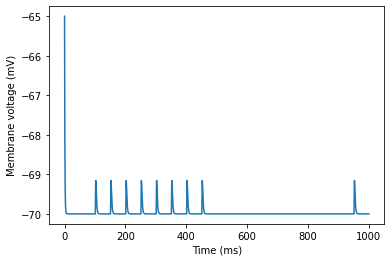

In [12]:
# This command gives us fancy interactive inline plots
%matplotlib inline

def plot_timecourse(time_array, dependent_var, newfigure=True, label=None, 
                    ylabel='Membrane voltage (mV)', constants=[]):
    """Convenience function to plot time courses of dependent variables"""
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)
        
plot_timecourse(time, v_soma)

The dual exponential model for the conductance time course has a closed form for the response due to a single pulse. Recall, for an AMPA receptor, response is fast and short due to permeability to mostly Na+ and K+ ions. 

Below we validate our .mod file implementation running in NEURON against this closed form solution. Recall the double exponential form:

$P_s(t) = kP_{max}(e^{\frac{1}{\tau_d}}- e^{\frac{1}{\tau_r}})$

where $k$ is the normalization constant, $\tau_d$ is the decay time constant and $\tau_r$ is the rise time constant. 



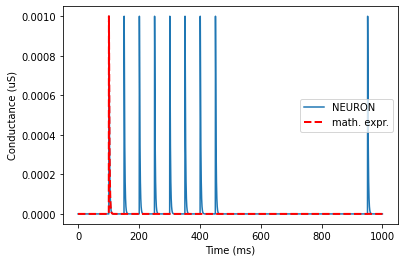

In [13]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON")

def dual_exp(t, tau_r, tau_d, t_start):
    """Compute the dual exponential time course using the closed form expression."""
    t = numpy.array(t)
    time_to_peak = (tau_r*tau_d)/(tau_d-tau_r)*numpy.log(tau_d/tau_r)
    factor = -numpy.exp(-time_to_peak/tau_r)+numpy.exp(-time_to_peak/tau_d)
    f_dual_exp = lambda t: (numpy.exp(-t/tau_d) - numpy.exp(-t/tau_r))/factor
    dual_exp = numpy.zeros_like(t)
    dual_exp[t>=t_start] = f_dual_exp(t[t>=t_start]-t_start)
    return dual_exp
    
plt.plot(time, 0.001*connection.weight[0]*dual_exp(time, synapse.tau_r_AMPA, synapse.tau_d_AMPA, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

(2) Next zero the AMPA conductance and validate NMDA conductance. 


In [14]:
synapse.gmax_NMDA = 0.001 # uS
synapse.mg = 0.0 # mM
synapse.gmax_AMPA = 0 # uS
neuron.h.run()

0.0

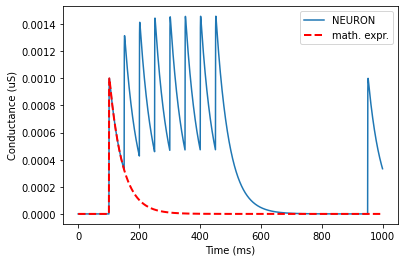

In [15]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON")
plt.plot(time, 0.001*connection.weight[0]*dual_exp(time, synapse.tau_r_NMDA, synapse.tau_d_NMDA, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

Note the difference between the AMPA (fast & short) receptor compared to the NMDA (slow & long). Both closed form solutions match the simulation results

### Configuring synapse to realistic biological ranges
Now that we've confirmed the behavior of our AMPA and NMDA conductances and the Mg2+ concentration, we can now start performing simulations using both receptors within known biological ranges. 


In [16]:
synapse.gmax_AMPA = 0.001 # uS
synapse.gmax_NMDA = 0.7 * 0.001 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1.0 # mM
g_NMDA = h.Vector()
g_NMDA.record(synapse._ref_g_NMDA)
g_AMPA = h.Vector()
g_AMPA.record(synapse._ref_g_AMPA)
neuron.h.run()

0.0

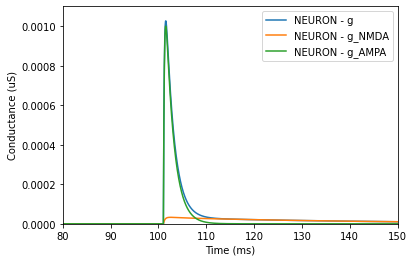

In [17]:
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON - g")
plot_timecourse(time, g_NMDA, ylabel="Conductance (uS)", label="NEURON - g_NMDA", newfigure=False)
plot_timecourse(time, g_AMPA, ylabel="Conductance (uS)", label="NEURON - g_AMPA", newfigure=False)
plt.axis([80.0, 150.0, 0.0, 0.0011])
plt.legend()

Longer tail for the entire neuron due to the contribution of the NMDA but synapse almost completely follows the AMPA receptor behavior. 

In [18]:
g_NMDA_1mM = numpy.zeros_like(g_NMDA)
g_NMDA_1mM[:] = g_NMDA

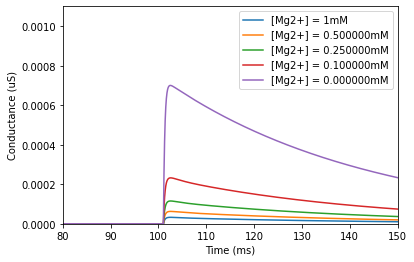

In [19]:
plot_timecourse(time, g_NMDA_1mM, ylabel="Conductance (uS)", label="[Mg2+] = 1mM")
mgs = [0.5, 0.25, 0.1, 0.0]
for mg in mgs:
    synapse.mg = mg
    neuron.h.run()
    plot_timecourse(time, g_NMDA, ylabel="Conductance (uS)", label="[Mg2+] = %fmM" % mg, newfigure=False)
plt.axis([80.0, 150.0, 0.0, 0.0011])
plt.legend()


The smaller the Mg2+ concentration, overall magnitude of NMDA conductance increases dramatically. Mg2+ is required for the voltage block of these receptors to be effective. 

Now, let's assess the voltage block curve of NMDA for [Mg2+]=1.0 in an _in silico_ reproduction the seminal experiment in Jahr and Stevens, 1990.

To do this, we need to:

1. Block the AMPA component of the conductance
2. Voltage clamp the soma at a given holding voltage
3. Run the stimulation simulation and extract the peak synaptic conductance
4. Repeat for different holding voltages
5. Fit the dependence of peak conductance on holding voltage to a sigmoid, plot.

We'll go through (1)-(3) below, and leave (4) and (5) to you the student as the exercise.

In [20]:
# 1) Block the AMPA component of the conductance
synapse.mg = 1.0 # [mM]
synapse.gmax_AMPA = 0.0 # Apply an "in silico AMPA blocker"
                        # Some things are easy in simulation ... 

In [21]:
# 2) Voltage clamp the soma at a given holding voltage
voltage_clamp = h.VClamp(0.5, sec=soma) # Create a voltage clamp electrode object and place it in the soma
voltage_clamp.amp[0] = -80.0 # Assign a clamping voltage
voltage_clamp.dur[0] = h.tstop # Clamp for the whole simulation duration

In [22]:
# 3) Run the stimulation simulation and extract the peak synaptic conductance
def extract_peaks(time, trace, event_times, window=10):
    """
    Computes the peak between event_times and returns the times of occurence and the maximums
    Useful for finding PSP or conductance peaks due to synaptic events.
    kwarg 'window' defines the time in ms after the event to consider when searching for the peak
    """
    
    peaks_list = []
    peaks_times_list = []
    for event_time in event_times:
        i_start = time.searchsorted(event_time)
        i_end = time.searchsorted(event_time+window)
        # find the index where the max occurs
        i_max = numpy.argmax(trace[i_start:i_end])
        # append the time and value at the max to the respective lists
        peaks_times_list.append(time[i_start:i_end][i_max])
        peaks_list.append(trace[i_start:i_end][i_max])
        
    return numpy.array(peaks_times_list), numpy.array(peaks_list)

In [23]:
def gNMDApeak_for_vclamp(v_clamp, eventNth=0):
    """returns the peak g_NMDA of the "eventNth" synaptic event for a given holding voltage"""
    voltage_clamp.amp[0] = v_clamp # Assign the clamping voltage
    neuron.h.run() # Simulate!
    g_NMDA = numpy.array(g_syn) # Get the resulting conductance as a numpy array (its only NMDA: AMPA is blocked) 
    time_arr = numpy.array(time) # Convert time h.Vector to a numpy array for subsequent operations
    peak_times, peaks = extract_peaks(time_arr, numpy.array(g_NMDA), spike_times) # extract the peaks and times
    peak_times_idx = time_arr.searchsorted(peak_times) # find array index of peak times 
    return peaks[eventNth] # return the peak conductance of the eventNth peak

## Exercise

To submit answers to these questions and get feedback, please return to the edX platform.

**Question 1**

4) Determine, as above, the g_NMDA peak for different holding voltages.
Hint: Use the above function, and loop, or use list comprehension.
Plot it. How does it look?

In [24]:
gNMDApeak_for_vclamp(-80.0)

1.7098858648658307e-05

In [25]:
v_range = numpy.linspace(-80.0, 60.0, 10)

Text(0, 0.5, 'Peak Conductance')

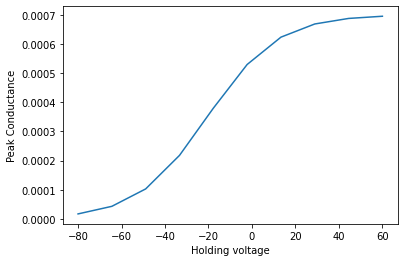

In [26]:
peak_gNMDA = [gNMDApeak_for_vclamp(i) for i in v_range]
plt.plot(v_range, peak_gNMDA)
plt.xlabel('Holding voltage')
plt.ylabel('Peak Conductance')

**Question 2**

5) Fit a sigmoid to the g_NMDA peak conductance dependence on holding voltage, and plot.
Hint: Use the fit function, and [curve_fit](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.curve_fit.html) (part of scipy) provided below.

Plot the simulation data and fit on the same axes.  Did *curve_fit* converge to a good fit?
How do the resulting fit parameters a & b compare to what was presented in the lecture, as determined by Jahr and Stevens, 1990 ?



In [27]:
from scipy.optimize import curve_fit

fit_func = lambda x, a, b: synapse.gmax_NMDA/(1.0 + a*numpy.exp(-x/b))
params = curve_fit(fit_func, v_range, peak_gNMDA)
[a,b] = params[0]
print (a,b)

0.2801193115269627 16.12950462832309


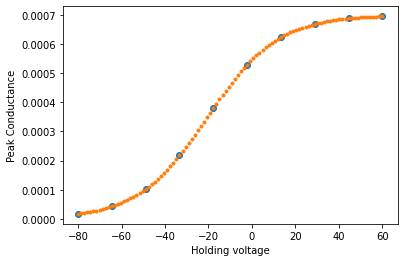

In [30]:
# calculate new vrange's and peak's
x_new = numpy.linspace(v_range[0], v_range[-1], 100)
y_new = fit_func(x_new, a, b)

plt.plot(v_range, peak_gNMDA,'o', x_new, y_new, '.')
plt.xlabel('Holding voltage')
plt.ylabel('Peak Conductance')
plt.show()

## **Implementing an Inhibitory Synapse**

Create a NEURON double exponential synapse at the center of the soma compartment (see [NEURON documentation](https://www.neuron.yale.edu/neuron/static/docs/help/neuron/neuron/mech.html#Exp2Syn) for more details).
This model has a rise time constant tau1 and a decay time constant tau2, and a reversal potential.  

In [21]:
synapse = h.Exp2Syn(soma(0.5)) #instead of an AMPA. / NMDA we use the double exponential model
synapse.tau1 = 0.5 # [ms]
synapse.tau2 = 10.0 # [ms]
synapse.e = -80.0

In [22]:
#Define stimuli once again
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 0.001        # [uS]

In [23]:
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)

Vector[11]

In [24]:
h.tstop = 1000.0 # ms
neuron.h.run()

0.0

In [25]:
# This command gives us fancy interactive inline plots
%matplotlib inline

def plot_timecourse(time_array, dependent_var, newfigure=True, label=None, ylabel='Membrane voltage (mV)', constants=[]):
    """Convenience function to plot time courses of dependent variables"""
    if newfigure:
        plt.figure()
    plt.plot(time_array, dependent_var, label=label)
    for constant in constants:
        plt.plot(time_array, constant*numpy.ones(len(time_array)))
    plt.xlabel('Time (ms)')
    plt.ylabel(ylabel)

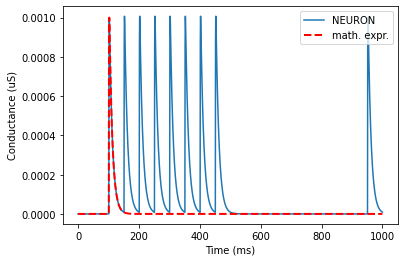

In [26]:
def dual_exp(t, tau_r, tau_d, t_start):
    """Compute the dual exponential time course using the closed form expression."""
    t = numpy.array(t)
    time_to_peak = (tau_r*tau_d)/(tau_d-tau_r)*numpy.log(tau_d/tau_r)
    factor = -numpy.exp(-time_to_peak/tau_r)+numpy.exp(-time_to_peak/tau_d)
    f_dual_exp = lambda t: (numpy.exp(-t/tau_d) - numpy.exp(-t/tau_r))/factor
    dual_exp = numpy.zeros_like(t)
    dual_exp[t>=t_start] = f_dual_exp(t[t>=t_start]-t_start)
    return dual_exp


plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="NEURON")

plt.plot(time, connection.weight[0]*dual_exp(time, synapse.tau1, synapse.tau2, 
                                                   t_start=100.0+connection.delay), 'r--', lw=2, label="math. expr.")
plt.legend()

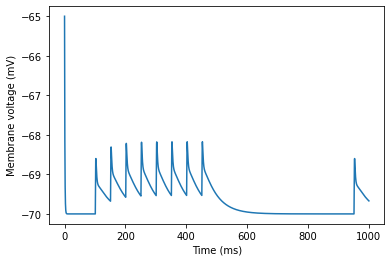

In [27]:
plot_timecourse(time, v_soma)

## Exercise

To submit answers to these questions and get feedback, please return to the edX platform.  

**Question 1**: Are you surprised??!  This is not an **excitatory** synapse (e.g. glutamatergic), but rather an **inhibitory** synapse (e.g. GABAergic).  Why is the soma voltage deflecting downwards for every synaptic pulse, rather than upwards?

**Answer 1**: Each soma voltage deflects downwards because the reversal potential is -80mV. This means that the signal hyperpolarizes the cell bringing its potential down to -80mV instead of more than the resting membrane potential. This happens because cell is open allows passage of chloride ions instead of Na+ or K+ ions which hyperpolarizes the cell instead of depolarizing it. 

**Question 2**: By changing only one parameter of the synapse, how can you make this an **excitatory** synapse? Convince yourself by re-running the simulation above.

**Answer 2**: By increasing the reversal potential more than the resting membrane potential, this can make this synapse excitatory.

## **Implementing Synaptic Dynamics**

In this section, we will interactively augment the AMPA and NMDA model of glutamate receptors we saw in the previous tutorial with a model of synapse dynamics, the Tsodyks-Markram model, as described in:

**G. Fuhrmann, I. Segev, H. Markram, M. Tsodyks. Coding of Temporal Information by Activity-Dependent Synapses. J. Neurophysiol. 2002, 87(1) 140-148; DOI: 10.1152/jn.00258.2001**

In doing so, you will learn how to implement the mathematical formulations of the model into NMODL syntax, and gain a deeper understanding of this widely used formulation of synapse dynamics. 

We use the **TsodyksMarkram_AMPA_NMDA.mod** for this synapse model. 

In [28]:
#Setup a new neuron to try this model
soma2 = neuron.h.Section()
soma2.L = 40
soma2.diam = 40
soma2.insert('pas')

__nrnsec_0x463e060

In [29]:
# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

In [30]:
synapse = h.TsodyksMarkram_AMPA_NMDA(soma(0.5))

In [31]:
#Define the stimuli
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

In [32]:
#Create vectors to record conductance, current, voltage, time intervals and the Use and R
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)
R_syn = h.Vector()
R_syn.record(synapse._ref_R)
Use_syn = h.Vector()
Use_syn.record(synapse._ref_Use)

Vector[18]

In [33]:
#Configure biologically accurate parameters for AMPA and NMDA

synapse.gmax_AMPA = 0.002 # uS
synapse.gmax_NMDA = 0.7 * 0.002 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1.0 # mM

#### Pseudo-linear parameters

Setup and look at pseudo-linear synapse dynamics (E3)

In [34]:
synapse.U1 = 0.2 # Baseline release probability
synapse.tau_rec = 200 # ms - recovery from depression
synapse.tau_facil = 200 # ms - relaxation from facilitation

h.tstop = 1000.0 # ms
neuron.h.run()

0.0

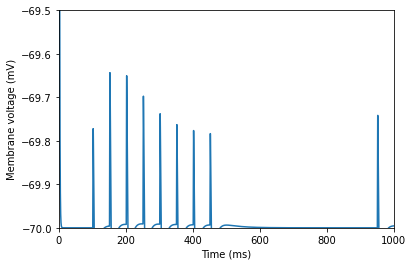

In [35]:
plot_timecourse(time, v_soma)
plt.axis([0, 1000, -70, -69.5]);

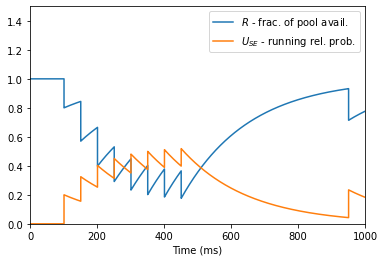

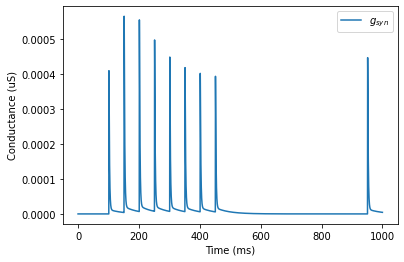

In [36]:
plot_timecourse(time, R_syn, ylabel="", label="$R$ - frac. of pool avail.")
plot_timecourse(time, Use_syn, ylabel="", label="$U_{SE}$ - running rel. prob.", newfigure=False)
plt.legend()
plt.axis([0,1000,0,1.5])
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="$g_{syn}$")
plt.legend()

#### Depressing parameters

Setup and look at depressing synapse (E2) dynamics 

In [37]:
synapse.U1 = 0.5 # Baseline release probability
synapse.tau_rec = 700 # ms - recovery from depression
synapse.tau_facil = 10 # ms - relaxation from facilitation

neuron.h.run()

0.0

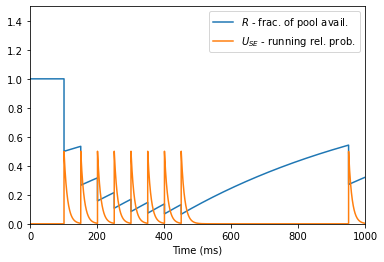

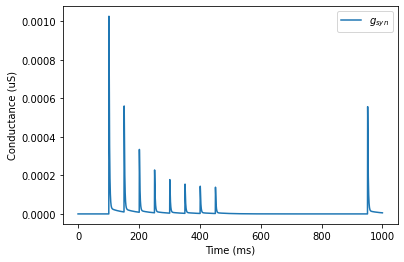

In [38]:
plot_timecourse(time, R_syn, ylabel="", label="$R$ - frac. of pool avail.")
plot_timecourse(time, Use_syn, ylabel="", label="$U_{SE}$ - running rel. prob.", newfigure=False)
plt.legend()
plt.axis([0,1000,0,1.5])
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="$g_{syn}$")
plt.legend()

## Exercise 

To submit answers to these questions and get feedback, please return to the edX platform.  

**Question 1**

Now, let's configure another parameter regime, as given below.  Simulate and plot the result.  Is this a E1 (facilitating), E2 (depressing), or E3 (pseudo-linear) synapse dynamics type, and why? 

**Answer 1**

Given the parameters and the result of the simulation, this is a depressing (E2) synapse dynamics. The time constant for recovery is much larger than the time constant for facilitation. It's considered depressing because the amplitude of the consequent voltage after the first spike decreases over time. The first spike has the largest access to all the resources of the cell, while the succeeding signals have lesser and lesser amounts of vesicles that can be readily released causing less receptors to be activated and thus smaller generated voltage signal. The probability of release maintains the same amplitude while the fraction of available vesicles decreases. Also, the amplitude of the generated spike after 500ms or recovery is less than the first spike. 

In [89]:
synapse.U1 = 0.7 # Baseline release probability
synapse.tau_rec = 500 # ms - recovery from depression
synapse.tau_facil = 15 # ms - relaxation from facilitation

neuron.h.run()

0.0

(0.0, 1000.0, 0.0, 1.5)

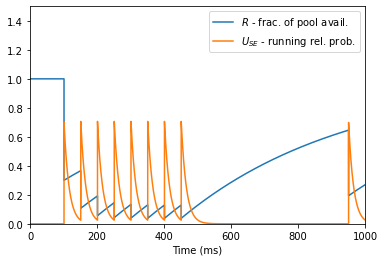

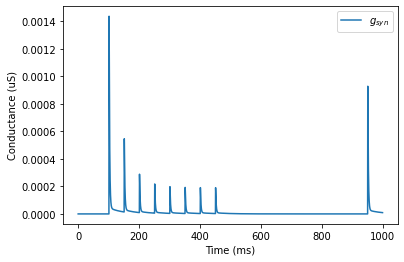

In [90]:
plot_timecourse(time, R_syn, ylabel="", label="$R$ - frac. of pool avail.")
plot_timecourse(time, Use_syn, ylabel="", label="$U_{SE}$ - running rel. prob.", newfigure=False)
plt.legend()
plt.axis([0,1000,0,1.5])
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="$g_{syn}$")
plt.legend()

**Question 2**

Now, let's configure another parameter regime, as given below.  Simulate and plot the result. Is this a E1 (facilitating), E2 (depressing), or E3 (pseudo-linear) synapse dynamics type, and why?

**Answer 2**
This is a facilitating (E1) dynamics. The time constant for facilitating is larger than the time constant for recovery. It's considered facilitating because the amplitude of the consequent voltage after the first spike increases over time. The first spike has the lowest spike due to having a very small initial probability of release while the succeeding signals have increasing probability of release causing more and more vesicles to release and thus slowly increasing generated voltage signal. The fraction of available resources likewise decreases over time as more and more vesicles are used. Also, the amplitude of the generated spike after 500ms or recovery is larger than the first spike. 

In [91]:
synapse.U1 = 0.05 # Baseline release probability
synapse.tau_rec = 50. # ms - recovery from depression
synapse.tau_facil = 500. # ms - relaxation from facilitation

neuron.h.run()

0.0

(0.0, 1000.0, 0.0, 1.5)

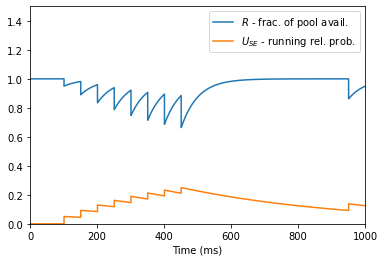

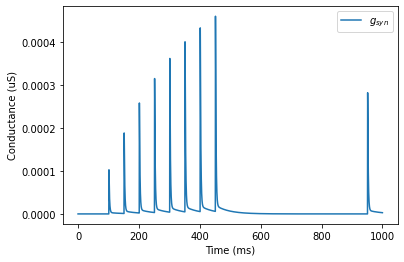

In [92]:
plot_timecourse(time, R_syn, ylabel="", label="$R$ - frac. of pool avail.")
plot_timecourse(time, Use_syn, ylabel="", label="$U_{SE}$ - running rel. prob.", newfigure=False)
plt.legend()
plt.axis([0,1000,0,1.5])
plot_timecourse(time, g_syn, ylabel="Conductance (uS)", label="$g_{syn}$")
plt.legend()